# Project 2(b)

### 0. Import Libraries

In [116]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import pickle
import tensorflow as tf
from PIL import Image
import os
import random
from tensorflow.keras import Input, Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from sklearn.utils import shuffle
from scipy.ndimage import rotate
from tensorflow.keras.optimizers import Adam

### 1. Read Data

In [117]:
input_file = 'train.p'

with open(input_file, mode='rb') as f:
    data = pickle.load(f)
    
X_data, y_data = data['features'], data['labels']

### 2. Data Preprocessing and Train_Test_Split

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
# np.vstack((X_train,X_train)).shape
y_train.shape


(31367,)

In [119]:
def generate_additional_data_rotate(x, y):
    
    # Horizontal flip
    h_flip = np.fliplr(x)
    
    # Vertical flip
    v_flip = np.flipud(x)
    
    # 90 degree rotation
    rot90 = np.rot90(x)

    x=np.concatenate((x,h_flip))
    y=np.concatenate((y,y))
    #...............................................#
            
    return x, y


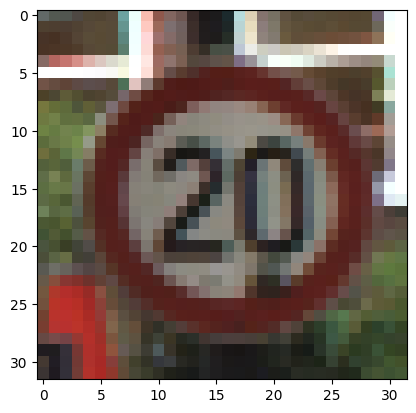

In [120]:
plt.imshow(X_data[201])

In [121]:
X_train, y_train = generate_additional_data_rotate(X_train, y_train)
# X_train, y_train = shuffle(X_train, y_train)
y_train.shape

(62734,)

In [122]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def normalize(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [-0.5, 0.5]
    param image_data: The image data to be normalized
    return: Normalized image data
    """

    data_min = np.min(image_data)
    data_max = np.max(image_data)
    normalized = -0.5 + (image_data - data_min) * (0.5 - (-0.5)) / (data_max - data_min)
    #...............................................#
    return normalized.astype(np.float32)

In [123]:
X_train = normalize(X_train)
X_test = normalize(X_test)

In [124]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(62734, 32, 32, 3) (7842, 32, 32, 3) (62734, 43) (7842, 43)


### 3. Build a CNN model

In [125]:
def CreateModel(input_shape=(32, 32, 3)):  # Adjust input_shape for your data
    model = Sequential([
        # First Conv Block
        Input(shape=input_shape),
        Conv2D(filters=64, kernel_size=(5,5), activation='relu',  padding='same'),
        MaxPool2D(pool_size=(2,2)),
        Dropout(rate=0.25),
        
        # Second Conv Block
        Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
        Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
        MaxPool2D(pool_size=(2,2)),
        Dropout(rate=0.25),
        
        # Classifier Head
        Flatten(),
        Dense(units=256, activation='relu'),  # Added activation
        Dropout(0.5),
        Dense(units=43, activation='softmax')
    ])
    
    model.summary()
    return model

#### Compilation of the model

In [126]:
# Compile the model
model = CreateModel()
model.compile(
    optimizer=Adam(learning_rate=0.001),  # You can adjust learning rate
    loss='categorical_crossentropy',     # For multi-class classification
    metrics=['accuracy']
)
#...................#
#................................#

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 568,171 (2.17 MB)

 Trainable params: 568,171 (2.17 MB)

 Non-trainable params: 0 (0.00 B)

In [127]:
epochs = 20
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/20
1961/1961 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.6215 - loss: 1.2556 - val_accuracy: 0.9388 - val_loss: 0.2351
Epoch 2/20
1961/1961 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.8849 - loss: 0.3572 - val_accuracy: 0.9705 - val_loss: 0.1097
Epoch 3/20
1961/1961 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9218 - loss: 0.2447 - val_accuracy: 0.9769 - val_loss: 0.0729
Epoch 4/20
1961/1961 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.9365 - loss: 0.1982 - val_accuracy: 0.9860 - val_loss: 0.0601
Epoch 5/20
1961/1961 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.9448 - loss: 0.1764 - val_accuracy: 0.9856 - val_loss: 0.0563
Epoch 6/20
1961/1961 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.9498 - loss: 0.1634 - val_accuracy: 0.9907 - val_loss: 0.0384
Epoch 7/20
1961/1961 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.9553 - loss: 0.1458 - val_accuracy: 0.9908 - val_loss: 0.0357
Epoch 8/20
1961/1961 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.9578 -

#### Plotting graphs for accuracy

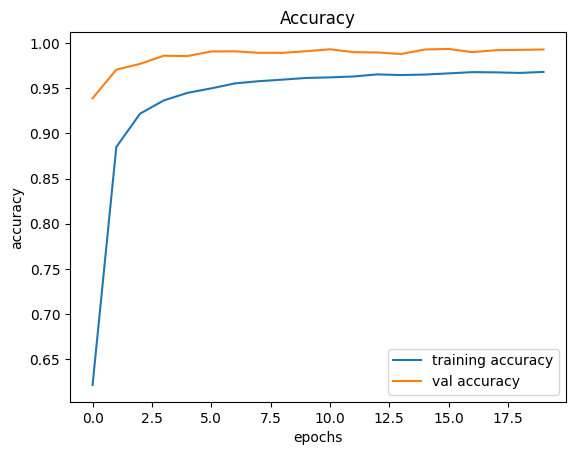

In [128]:
# Accuracy 
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

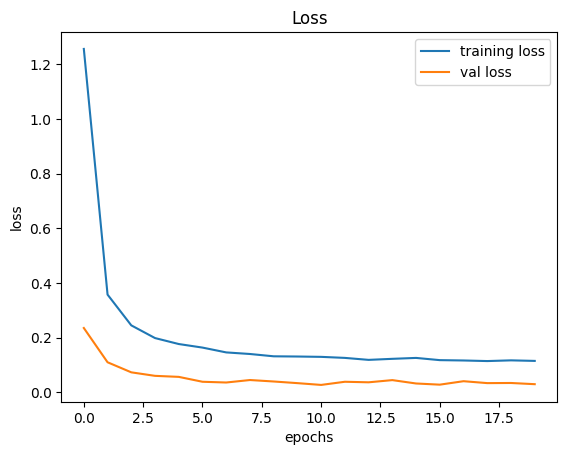

In [129]:
# Loss
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

#### Save the model


In [130]:
model.save("traffic_classifier_2b.h5")

برای این داده ها ،با توجه به نمودار های دقت و خطای مدل،مدل این قسمت مناسب تر است چرا که علاوه بر دقت بالاتر،بدلیل نرمالایز کردن داده ها و همچنین داشتن داده بیشتر ،الگوریتم در زمان بسیار کمتری همگرا میشود و خطای کمتری نیز دارد